In [12]:
import sys
sys.path.append("/home/wanxinli/OTTEHR/")

from ast import literal_eval
from common import *
from mimic_common import *
from multiprocess import Pool
import os
import ot
import ot.plot
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import time
from sklearn.manifold import TSNE
import plotly.express as px
import umap
from matplotlib import pyplot as plt

In [13]:


output_dir = os.path.join(os.path.expanduser("~"), f"OTTEHR/outputs/mimic")
print(f"Will save outputs to {output_dir}")

""" 
Read in the original dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
print(admid_diagnosis_df)


"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(source_features, target_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    source_reps = source_pca.fit_transform(source_features)

    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return source_reps, target_reps


""" 
Run multiple iterations using linear regression
"""
n_components = 50

# suffix = None
# group_name = 'gender'
# group_1 = 'M'
# group_2 = 'F'

# suffix = None
# group_name = 'ethnicity'
# group_1 =   'HISPANIC_OR_LATINO'
# group_2 = 'ASIAN'
# # group_2 = 'WHITE'

# suffix = None
# group_name = 'marital_status'
# group_1 =   'MARRIED'
# group_2 = 'SEPARATED'

# suffix = None
group_name = 'marital_status'
group_1 =  'MARRIED'
group_2 = 'SEPARATED'

# suffix = None
# group_name = 'insurance'
# group_1 =  'Medicare'
# group_2 = 'Medicaid'

# Select a subset of the data (newborn)
# admid_diagnosis_df = admid_diagnosis_df[admid_diagnosis_df['adm_type'] == 'NEWBORN']
# suffix = "newborn"

# suffix = None
# group_name = 'insurance'

# group_name = 'marital_status'
# groups = ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED', 'SEPARATED']


group_1_count = 120
group_2_count = 100


selected_df = select_df_cts(admid_diagnosis_df, group_name, group_1, group_2, source_count=group_1_count, target_count=group_2_count)

source_features, source_labels, target_features, target_labels = gen_features_duration(selected_df, group_name, group_1, group_2)

source_reps, target_reps = custom_train_reps(source_features, target_features, n_components, pca_explain=False)


Will save outputs to /home/wanxinli/OTTEHR/outputs/mimic
         adm_type gender                                          ICD codes  \
admid                                                                         
172335  EMERGENCY      F  [403.01, 486, 582.81, 585.5, 425.4, 276.2, 710...   
173633  EMERGENCY      F  [403.01, 585.6, 583.81, 710.0, 558.9, 287.5, 2...   
174105  EMERGENCY      M               [531.00, 410.71, 285.9, 414.01, 725]   
109976  EMERGENCY      M                             [191.5, 331.4, 530.81]   
178393   ELECTIVE      M       [414.01, 411.1, 482.83, 285.9, 272.0, 305.1]   
...           ...    ...                                                ...   
172304   ELECTIVE      F       [202.80, 348.5, 784.3, 401.9, 272.0, 530.81]   
152542  EMERGENCY      M  [566, 250.62, 357.2, V58.67, 427.31, 401.9, 42...   
161999  EMERGENCY      M  [434.11, 348.5, 348.4, 430, 348.30, 997.31, 51...   
189314  EMERGENCY      F  [346.80, 784.3, 745.5, 781.94, 368.40, 781.3, ..

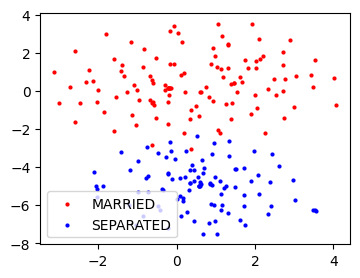

In [14]:
tsne = TSNE(n_components=2, random_state=0)
source_proj = tsne.fit_transform(source_reps)
target_proj = tsne.fit_transform(target_reps)
fig = plt.figure(figsize=(4, 3))
plt.scatter(source_proj[:, 0], source_proj[:, 1], color='red', s=4, label=group_1)
plt.scatter(target_proj[:, 0], target_proj[:, 1], color='blue', s=4, label=group_2)
plt.legend()
# plt.savefig(os.path.join(output_dir, f'{group_name}_{group_1}_vs_{group_2}_embedding.pdf'), bbox_inches='tight')
plt.show()

In [23]:
group_name = 'marital_status'
groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

# group_name = 'insurance'
# groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']

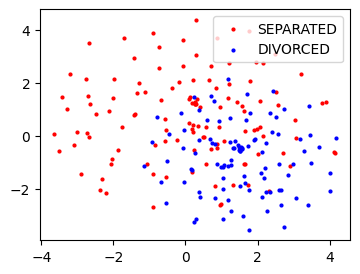

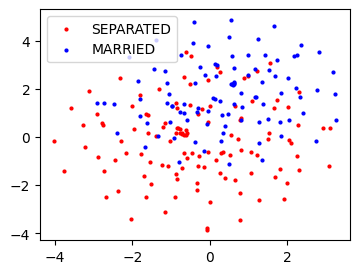

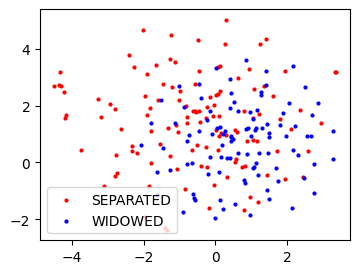

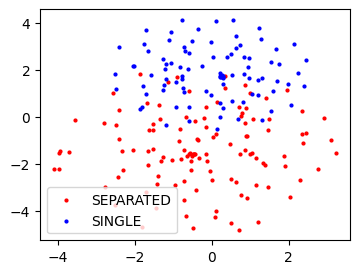

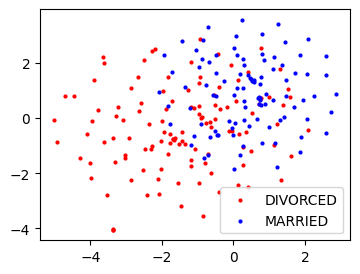

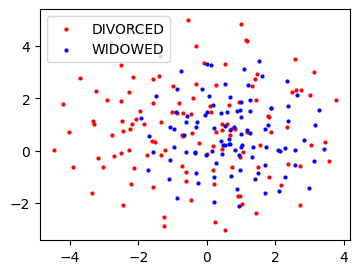

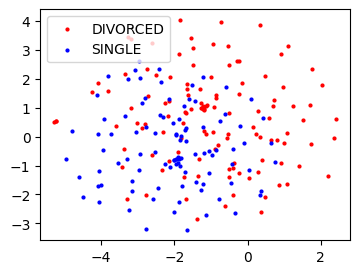

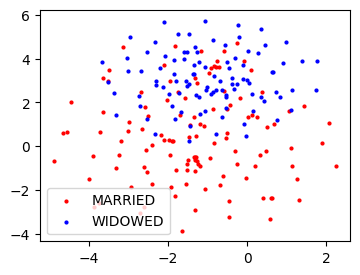

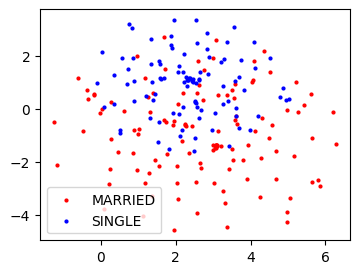

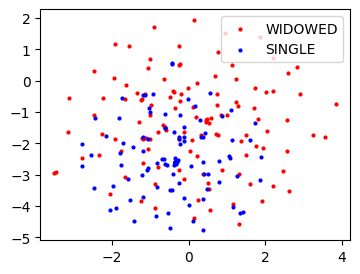

In [24]:
group_1_count = 120
group_2_count = 100

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        group_1 = groups[i]
        group_2 = groups[j]

        selected_df = select_df_cts(admid_diagnosis_df, group_name, group_1, group_2, source_count=group_1_count, target_count=group_2_count)

        source_features, source_labels, target_features, target_labels = gen_features_duration(selected_df, group_name, group_1, group_2)

        source_reps, target_reps = custom_train_reps(source_features, target_features, n_components, pca_explain=False)

        tsne = TSNE(n_components=2, random_state=0)
        source_proj = tsne.fit_transform(source_reps)
        target_proj = tsne.fit_transform(target_reps)
        fig = plt.figure(figsize=(4, 3))
        plt.scatter(source_proj[:, 0], source_proj[:, 1], color='red', s=4, label=group_1)
        plt.scatter(target_proj[:, 0], target_proj[:, 1], color='blue', s=4, label=group_2)
        # plt.xlim(-9, 9)
        # plt.ylim(-9, 9)
        plt.legend()
        plt.savefig(os.path.join(output_dir, f'{group_name}_{group_1}_vs_{group_2}_embedding.pdf'), bbox_inches='tight')
        plt.show()